In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
address=r"C:\Users\Yashraj\OneDrive - IIT Hyderabad\IC_Analysis\0. Main\CC_gaussian _Cleaned_IC Curve (final)\features"

database=pd.read_pickle(address)
database.columns

Index(['max_ic', 'max_v', 'max2_ic', 'max2_v', 'slope_left', 'slope_right',
       'Q_AtoB', 'Q_LtoR', 'energy', 'ic_capacity', 'capacity'],
      dtype='object')

In [7]:
database.drop([17],axis=0,inplace=True)
database.reset_index(drop=True,inplace=True)

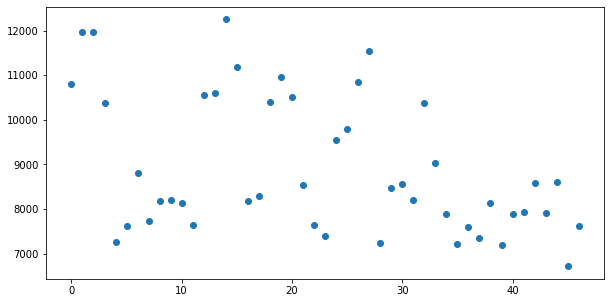

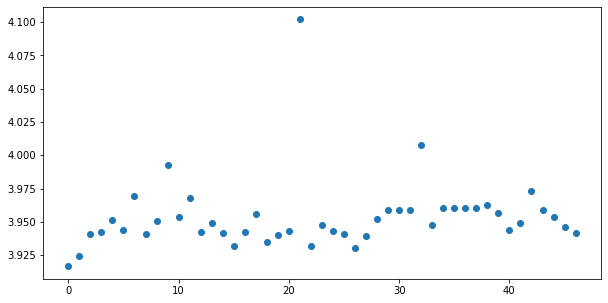

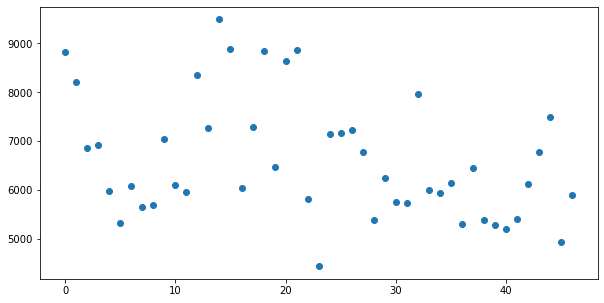

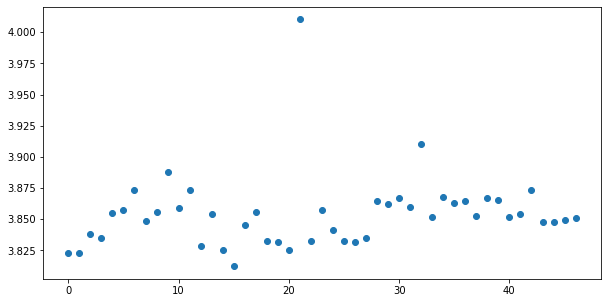

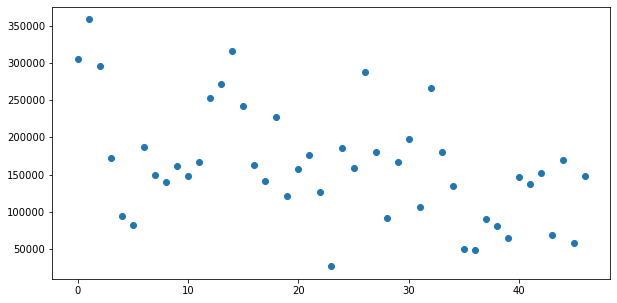

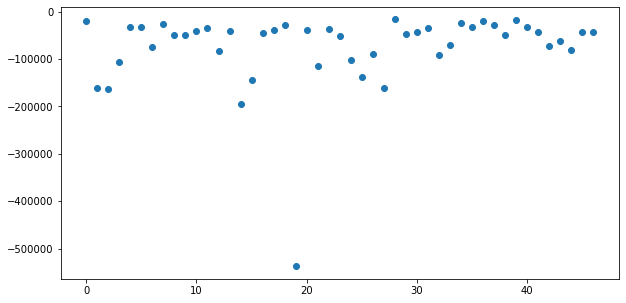

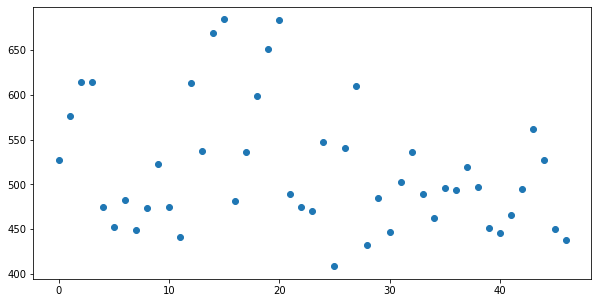

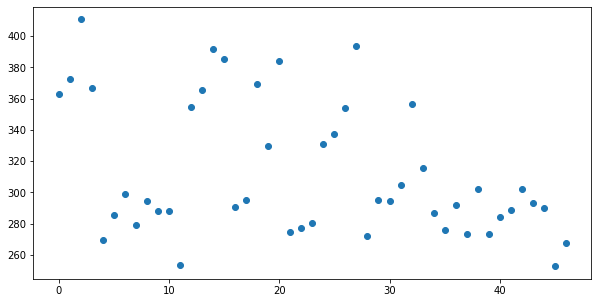

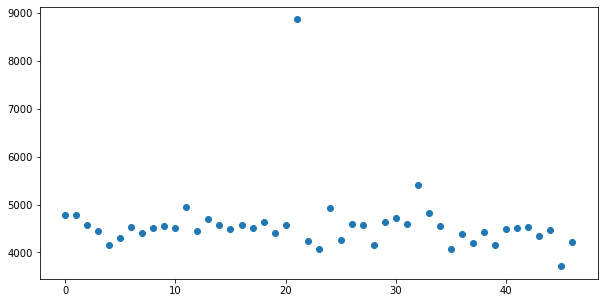

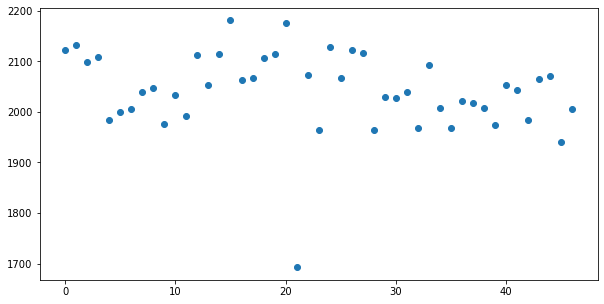

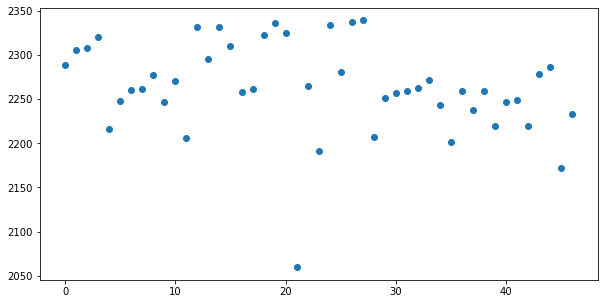

In [13]:
size=database.shape[1]

for col in range(size):
    plt.figure(figsize=(10,5))
    x=database.index
    y=database.iloc[:,col]
    plt.scatter(x,y)
    
    name='org-'+database.columns[col]
    plt.savefig(name,dpi=500)
    plt.show()


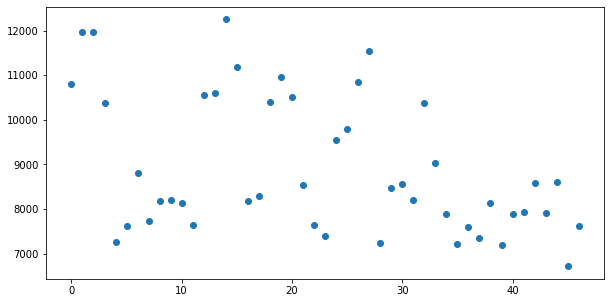

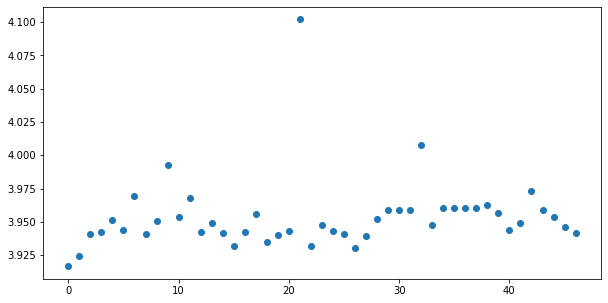

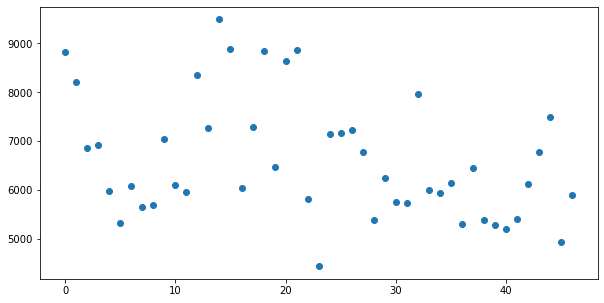

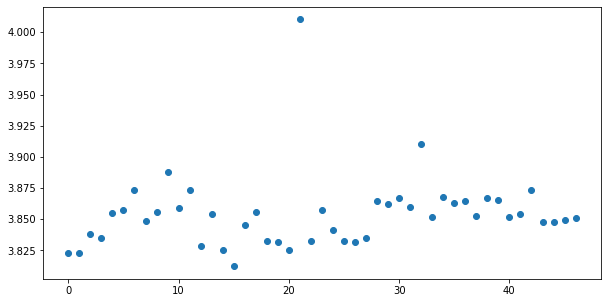

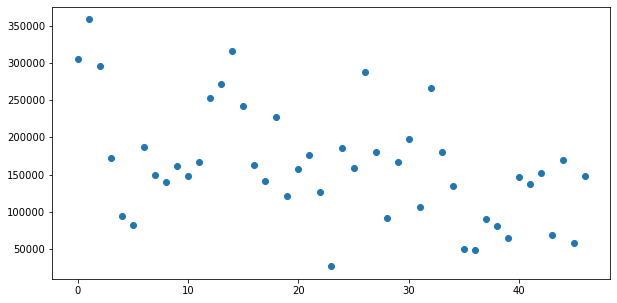

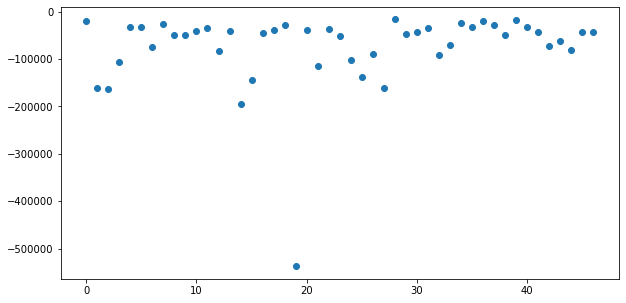

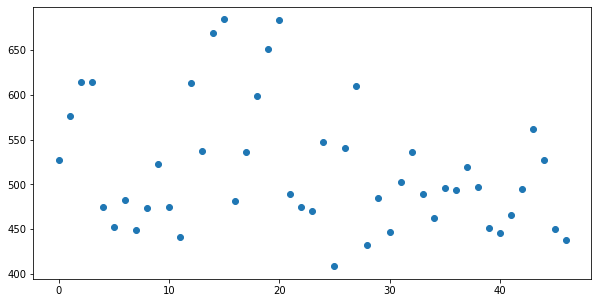

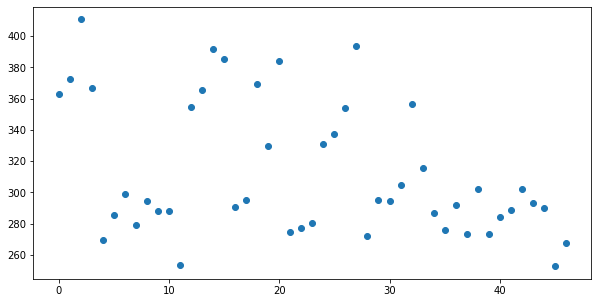

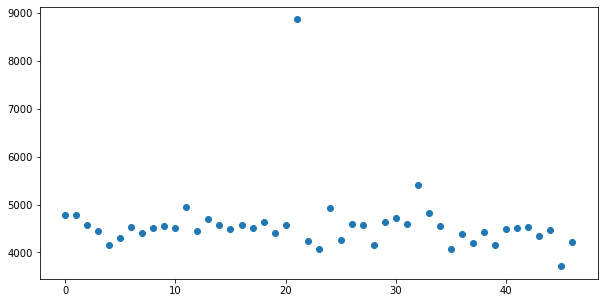

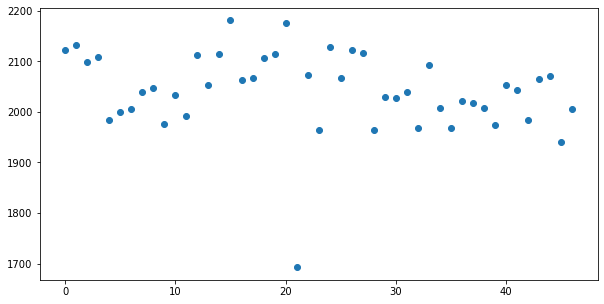

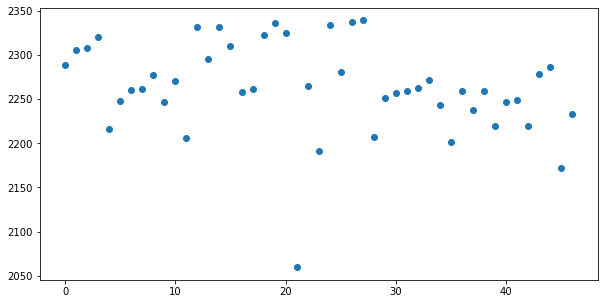

In [ ]:
database

In [14]:
#X=data.drop(['ic_capacity', 'capacity'],axis=1).values

X=database.drop(['ic_capacity', 'capacity'],axis=1).values
y= database['capacity'].values.reshape(-1,1)
print(X.shape)
print(y.shape)

sc=StandardScaler()
X=sc.fit_transform(X)

(47, 9)
(47, 1)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

<a><h3><u> Create a Model Class

In [16]:
# input - 9 features so 9 NEURONS
# 2 hiden layers of 18, 20 NEURONS each
# output layer  = 3 categories so , 3 NEURONS

# pre activation function - (aggregator) - Linear function - W*X+B
# Activation function - Relu

# loss - MSE (as we need probabilities)
# algorithm - Adam 

In [17]:
class TabularModel(nn.Module):

    def __init__(self, n_cont, out_sz, layers):
        super().__init__()
        
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        
        for i in layers:
            layerlist.append(nn.Linear(n_cont,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            n_cont = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        
        x = self.bn_cont(x)
        x = self.layers(x)
        return x

In [19]:
torch.manual_seed(33)
model = TabularModel(X.shape[1], 1, [16,32,16])
#[16,32,64,32,16]

In [20]:
model

TabularModel(
  (bn_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
)

<a><h3><u> Define loss function & optimizer

In [ ]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
model.layers[0].bias.data

In [ ]:
epochs = 8501
losses = []

for i in range(epochs):
    
    y_pred = model.forward(X_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss.item())

# A neat trick to save screen space:
    if i%500 == 0:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [ ]:
# To Evaluate the Entire Test set
# no_grad ensure that gradient is not calculated and weights and bias are not updated

with torch.no_grad():
    y_val = model.forward(X_test)
    loss = torch.sqrt(criterion(y_val , y_test))
print(f'{loss:10.8f}')

In [ ]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(y_val.shape[0]):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, y_val)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_val))

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, y_val)